# PluriGaussian simulations

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import urllib.request

flagInternetAvailable = False

Defining some essential parameters:

In [3]:
ndim = 2
gl.defineDefaultSpace(gl.ESpaceType.RN, ndim);

nbsimu = 20
nbcc   = 4
cmap   = ListedColormap(['red', 'blue', 'yellow'])

Downloading the data base (from the distribution **Data.NF**) 

In [4]:
fileNF='Data.NF'
if flagInternetAvailable:
    path_nf, head = urllib.request.urlretrieve('https://soft.minesparis.psl.eu/gstlearn/data/PluriGaussian/'+fileNF,'./'+fileNF)
else:
    path_nf='./'+fileNF

data = gl.Db.createFromNF(path_nf)

Creating the output Grid, the Model (Cubic) and the Neighborhood (Unique):

In [5]:
grid = gl.DbGrid.create(nx=[110,110])

model = gl.Model.createFromParam(type=gl.ECov.CUBIC, ranges=[50,30])

neigh = gl.NeighUnique()

##### Displaying Data:

Samples are represented with a different color per **facies**:
- first facies in *red*
- second facies in *blue*
- third facies in *yellow*

Samples which must belong to the same connected component (see variable **connect**) are displayed with large symbols.

In [6]:
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 7
Maximum Number of UIDs       = 7
Total number of samples      = 100
Number of active samples     = 99

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Simu.V1.S1 - Locator = NA
Column = 4 - Name = facies - Locator = z1
Column = 5 - Name = sel - Locator = sel
Column = 6 - Name = connect - Locator = NA

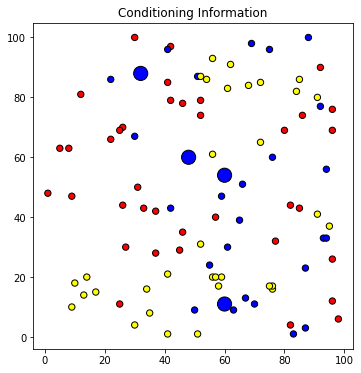

In [7]:
gp.setDefaultGeographic(dims=[6,6])
ax = data.plot(name_color="facies", name_size="connect", 
               edgecolors='black', sizmin=40, cmap=cmap)
ax.decoration(title="Conditioning Information")

Creating Proportions and Lithotype Rule

In [8]:
props = gl.dbStatisticsFacies(data)
rule = gl.Rule.createFromNames(["S","S","F1","F2","F3"])

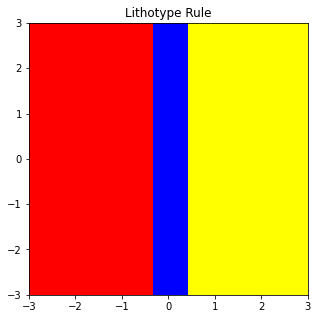

In [9]:
ax = rule.plot(proportions = props, cmap=cmap)
ax.decoration(title="Lithotype Rule")

Calculate the Experimental Variogram of the Underlying Gaussian Random Function and fit the Model (used in PGS).

In [10]:
varioparam = gl.VarioParam.createOmniDirection(dpas=5, npas=20)
ruleprop = gl.RuleProp.createFromRule(rule, props)
vario = gl.variogram_pgs(data, varioparam, ruleprop)

model_gaus = gl.Model()
err = model_gaus.fit(vario, types=[gl.ECov.CUBIC], constraints=gl.Constraints(1.))

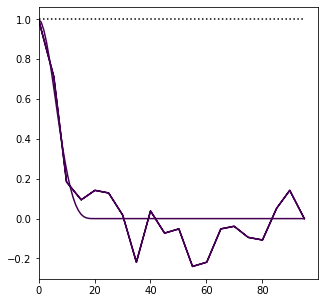

In [11]:
ax = gp.varmod(vario, model_gaus, asCov=True)

PluriGaussian Simulation

In [12]:
err = gl.simpgs(data, grid, ruleprop, model_gaus, None, neigh, nbsimu=nbsimu,
                namconv = gl.NamingConvention("SimuPGS"))

Show several simulation outcomes

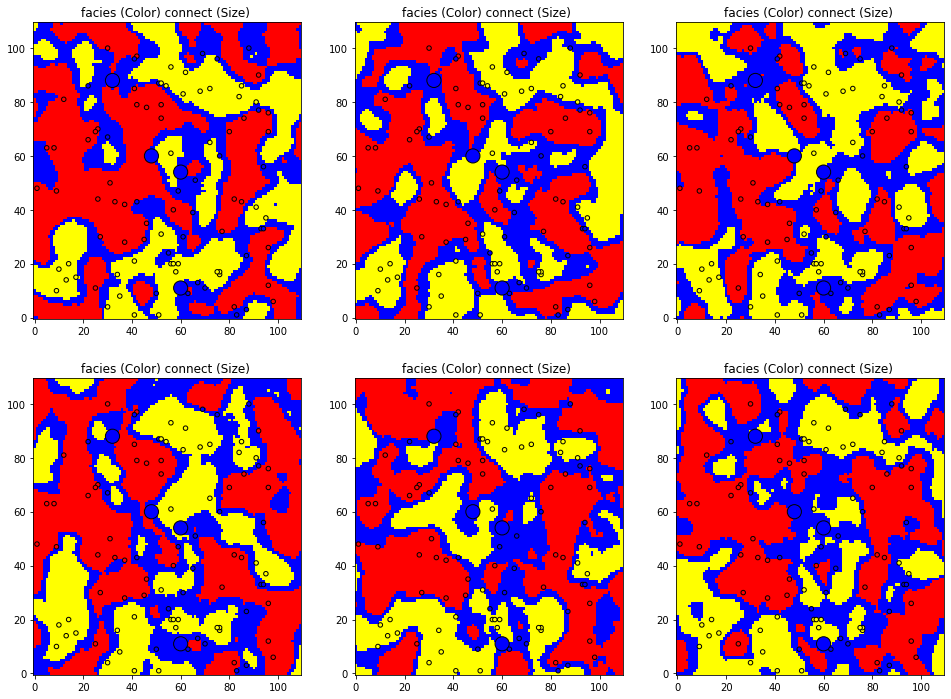

In [13]:
fig, axs = plt.subplots(2,3,figsize=(22,12))
axs[0,0].gstgrid(grid,"SimuPGS.1", cmap=cmap)
axs[0,0].gstpoint(data,name_color="facies", name_size="connect", edgecolors='black', 
                  sizmin=20, cmap=cmap)
axs[0,1].gstgrid(grid,"SimuPGS.2", cmap=cmap)
axs[0,1].gstpoint(data,name_color="facies", name_size="connect", edgecolors='black', 
                  sizmin=20, cmap=cmap)
axs[0,2].gstgrid(grid,"SimuPGS.4", cmap=cmap)
axs[0,2].gstpoint(data,name_color="facies", name_size="connect", edgecolors='black', 
                  sizmin=20, cmap=cmap)
axs[1,0].gstgrid(grid,"SimuPGS.6", cmap=cmap)
axs[1,0].gstpoint(data,name_color="facies", name_size="connect", edgecolors='black', 
                  sizmin=20, cmap=cmap)
axs[1,1].gstgrid(grid,"SimuPGS.10", cmap=cmap)
axs[1,1].gstpoint(data,name_color="facies", name_size="connect", edgecolors='black', 
                  sizmin=20, cmap=cmap)
axs[1,2].gstgrid(grid,"SimuPGS.11", cmap=cmap)
axs[1,2].gstpoint(data,name_color="facies", name_size="connect", edgecolors='black', 
                  sizmin=20, cmap=cmap)
fig.subplots_adjust(right=0.7)

Define an Acceptation-Rejection function

Acceptation internal function: For a given simulation outcome

- Select the **Target Facies** and build its Connected Components,
- Read the indices of the connected component(s) at constraining wells,
- Return the score: **True** if these indices are similar and **False** otherwise.

In [14]:
def accept(data, grid, name, verbose=False, transBinary=True, faccc=2):
    
    # Get the indices of samples which should be connected (starting from 0)
    rankData = [i for i in range(data.getSampleNumber()) if data[i,"connect"] > 0]
    rankGrid = grid.locateDataInGrid(data, rankData)
    if verbose:
        print("Number of conditioning data =",len(rankData))
        print("Their ranks in the input Data Base =",rankData)
        print("Their ranks in the output Data Base =",rankGrid)
    
    # Perform the labelling into connected components
    grid.setLocator(name, gl.ELoc.Z, cleanSameLocator=True)
    err = gl.dbMorpho(grid, gl.EMorpho.CC, vmin=faccc-0.5, vmax=faccc+0.5)
    cc_list = grid[rankGrid,"Morpho*"]
    if verbose:
        print("List of their connected components indices =",cc_list)

    # Check that the data points belong to the same connected component
    number = len(np.unique(cc_list))
    return_val = (number == 1)
    if verbose:
        print("Acceptation score =",return_val)
        
    # Convert the valid Simulation outcome into a binary image
    if return_val and transBinary:
        grid[name] = grid["Morpho*"] == cc_list[0]
    
    grid.deleteColumn("Morpho*")
    return return_val

Check the acceptation / rejection function on the Simulation outcome #1.

In [15]:
isValid = accept(data, grid, "SimuPGS.1", verbose=True, transBinary=False)

Number of conditioning data = 4
Their ranks in the input Data Base = [4, 12, 15, 16]
Their ranks in the output Data Base = [6000 1270 6648 9712]
List of their connected components indices = [1. 1. 1. 1.]
Acceptation score = True


Check the acceptation function on all simulation outcomes

In [16]:
for i in range(nbsimu):
    name = "SimuPGS." + str(i+1)
    isValid = accept(data, grid, name, False)
    if not isValid:
        grid.deleteColumn(name)
    else:
        print("Simulation ",name,"is valid")

Simulation  SimuPGS.1 is valid
Simulation  SimuPGS.2 is valid
Simulation  SimuPGS.4 is valid
Simulation  SimuPGS.6 is valid
Simulation  SimuPGS.10 is valid
Simulation  SimuPGS.11 is valid
Simulation  SimuPGS.14 is valid
Simulation  SimuPGS.15 is valid
Simulation  SimuPGS.18 is valid
Simulation  SimuPGS.19 is valid


Derive the Probability Map

In [17]:
err = grid.statistics(["SimuPGS*"],[gl.EStatOption.MEAN], flagStoreInDb=True)

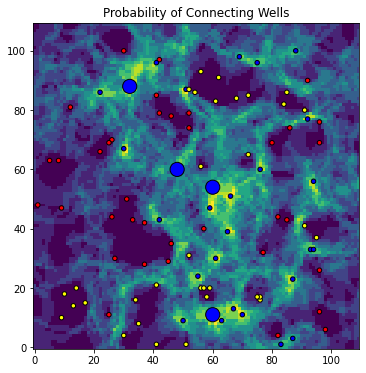

In [18]:
ax = grid.plot("Stats.MEAN")
ax = data.plot(name_color="facies", name_size="connect", edgecolors='black', sizmin=20, 
               cmap=cmap)
ax.decoration(title="Probability of Connecting Wells")